# Лекция 8: Рандомизированная линейная алгебра

## Краткий обзор предыдущей лекции


SVD и алгоритмы для его вычисления: разделяй-и-властвуй, QR, Якоби, бисекция.

## Сегодняшняя лекция

Сегодня мы кратко погрузимся в рандомизированную линейную алгебру.

Хорошим источником для чтения является (https://arxiv.org/pdf/2002.01387.pdf)

## Алгоритмы бывают детерминированными и рандомизированными

Все вычисления, которые мы рассматривали до сегодняшнего дня, были **детерминированными**.

Однако снижение сложности может быть достигнуто с помощью рандомизированных (стохастических) вычислений.

Пример: рандомизированное умножение матриц.


## Оказывается, мы можем проверить, если $ A B = C$ за $\mathcal{O}(n^2)$ операций.

Дано: $A, B, C$ — матрицы $n \times n$.

Задача: проверить, если $ A B = C$.

Как?

## Ответ дает [Алгоритм Фрейвальдса](https://en.wikipedia.org/wiki/Freivalds%27_algorithm)

В его основе -- проверка на равенство матриц путем умножения на случайные векторы!

Сложность составляет $k n^2$, вероятность ошибки равна $\frac{1}{2^k}$.


## А что мы можем сделать с умножением матриц?

Но можем ли мы умножать матрицы быстрее, используя идеи рандомизации?

## Можно построить быстрое, но приближенное умножение матриц

- Мы знаем, что умножение матриц $AB$ стоит $O(mnp)$ для матриц размеров $m \times p$ и $p \times n$
- Мы можем построить аппроксимацию этого произведения, выбирая строки и столбцы множителей

**Вопрос:** как их выбирать?

**Ответ:** генерировать вероятности из их норм!

- Итак, окончательное выражение аппроксимации

$$ AB \approx \sum_{t=1}^k \frac{1}{kp_{i_t}} A^{(i_t)} B_{(i_t)}, $$

где $A^{(i_t)}$ - столбец $A$, а $B_{(i_t)}$ - строка $B$

- Снижение сложности с $O(mnp)$ до $O(mnk)$

In [18]:
import numpy as np

n = 5
p = 10000
m = 5
A = np.random.randn(n, p)
B = np.random.randn(p, m)
C = A @ B

def randomized_matmul(A, B, k):
    p1 = A.shape[1]
    p = np.linalg.norm(A, axis=0) * np.linalg.norm(B, axis=1)
    p = p
    p = p.ravel() / p.sum()
    n = A.shape[1]
    p = np.ones(p1)
    p = p/p.sum()
    idx = np.random.choice(np.arange(n), (k,), False, p)
    #d = 1 / np.sqrt(k * p[idx])
    d = 1.0/np.sqrt(k)#np.sqrt(p1)/np.sqrt(k*p[idx])
    A_sketched = A[:, idx]*np.sqrt(p1)/np.sqrt(k)#* d[None, :]
    B_sketched = B[idx, :]*np.sqrt(p1)/np.sqrt(k) #* d[:, None]
    C = A_sketched @ B_sketched
    #print(d)
    return C

def randomized_matmul_topk(A, B, K):
    
    norm_mult = np.linalg.norm(A,axis=0) * np.linalg.norm(B,axis=1)
    top_k_idx = np.sort(np.argsort(norm_mult)[::-1][:K])
    
    A_top_k_cols = A[:, top_k_idx]
    B_top_k_rows = B[top_k_idx, :]

    C_approx = A_top_k_cols @ B_top_k_rows
    return C_approx

num_items = 4000
C_appr_samples = randomized_matmul(A, B, num_items)
#print(C_appr_samples, 'appr')
#print(C, 'true')
C_appr_topk = randomized_matmul_topk(A, B, num_items)
print(np.linalg.norm(C_appr_topk - C, 2) / np.linalg.norm(C, 2))
print(np.linalg.norm(C_appr_samples - C, 2) / np.linalg.norm(C, 2))

0.47962255089465017
1.8999756830536187


## Оценка ошибки аппроксимации потребует знания теории вероятностей

$$ \mathbb{E} [\|AB - CR\|^2_F] = \frac{1}{k} \left(\sum_{i=1}^n \| A^{(i)} \|_2 \| B_{(i)} \|_2\right)^2   - \frac{1}{k}\|AB\|_F^2 $$ 

- Возможны другие вероятности выборки
- Используйте аппроксимацию
$$ AB \approx ASD(SD)^\top B  = ACC^{\top}B$$
можно заменить выборку и масштабирование другой матрицей, которая

    - уменьшает размерность
    - достаточно точно аппроксимирует

**Вопрос:** какие матрицы можно использовать?

## След матрицы тоже можно оценить

Многие задачи могут быть записаны в форме оценки следа:

$$\mathrm{Tr}(A) = \sum_{i} A_{ii}.$$

Можем ли мы вычислить след матрицы, если у нас есть доступ только к произведениям матрицы на вектор?

## Есть две оценки -- одна с меньшей дисперсией, другая с большей

Рандомизированные оценщики следа могут быть вычислены по следующей формуле:

$$\mathrm{Tr}(A) = E_w w^* A w, \quad E ww^* = 1$$ 

Для выборки мы берем $k$ независимых образцов $w_k$, получаем случайную величину $X_k$ и усредняем результаты.

**Оценщик следа Жирара**: Выборка $w \sim N(0, 1)$

Тогда, $\mathrm{Var} X_k = \frac{2}{k} \sum_{i, j=1}^n \vert A_{ij} \vert^2 = \frac{2}{k} \Vert A \Vert^2_F$

**Оценщик следа Хатчинсона**: Пусть $w$ будет случайным вектором Радемахера (т.е. элементы выбираются из равномерного распределения.

Он дает оценщик с минимальной дисперсией.

## Можно строить более тонкие оценки на основе внутренней размерности

Дисперсия следа может быть оценена в терминах **внутренней размерности** (intdim) для симметричных положительно определенных матриц.

Она определяется как $\mathrm{intdim}(A) = \frac{\mathrm{Tr}(A)}{\Vert A \Vert_F}$. Легко показать, что

$$1 \leq \mathrm{intdim}(A) \leq ?.$$

Тогда вероятность большого отклонения может быть оценена как

$$P( \vert \overline{X}_k - \mathrm{Tr}(A) \vert \geq t \mathrm{Tr}(A)) \leq \frac{2}{k \mathrm{intdim}(A) t^2}$$

## Лучшие оценки для симметричных положительно определенных матриц

Если $A$ - симметричная положительно определенная матрица, то

$$P(\overline{X}_k \geq \tau \mathrm{Tr}(A) ) \leq \exp\left(-1/2 \mathrm{intdim}(A) (\sqrt{\tau} - 1)^2)\right) $$

Аналогичное неравенство справедливо и для нижней границы.

Эта оценка намного лучше.

Интересное (и часто упускаемое из виду) свойство стохастического оценщика заключается в том, что он поставляется со стохастической оценкой дисперсии (из выборки!)

Предупреждение: нам все равно нужно $\varepsilon^{-2}$ выборок, чтобы достичь точности $\varepsilon$ при использовании независимых выборок.

### Пример результата, где применялось -- надо читать исходную статью ([original paper](https://openreview.net/pdf?id=HyebplHYwB))

<img src="./gw_matexp.png">

## Где еще помогают стохастические методы?

- SVD
- Линейные системы


## Рандомизированный SVD ([Halko et al, 2011](https://epubs.siam.org/doi/pdf/10.1137/090771806?casa_token=isi3yX3QdPEAAAAA:j-7Qk87vS0kjKqGMLYeX3xg4QxqqyM8s4wn-XGX-SLOS2BRChFDRTPX-x9Hf7ltfuZYg9xsA0zksw1U))

- Напоминание о постановке задачи

$$ A \approx U\Sigma V^\top, $$

где $A$ имеет размер $m \times n$, $U$ имеет размер $m \times k$ и $V$ имеет размер $n \times k$.

- Мы уже знаем, что сложность аппроксимации ранга $k$ составляет $O(mnk)$
- Как мы можем уменьшить эту сложность?

- Предположим, что мы знаем ортогональную матрицу $Q$ размера $m \times k$ такую, что 

$$A \approx Q Q^{\top}A $$

- Другими словами, столбцы $Q$ представляют ортогональный базис в пространстве столбцов матрицы $A$
- Тогда следующие детерминированные шаги могут дать факторы $U$, $\Sigma$ и $V$, соответствующие SVD матрицы $A$
    - Формируем матрицу $B = Q^{\top}A$ размера $k \times n$
    - Вычисляем SVD малой матрицы $B = \hat{U}\Sigma V^{\top}$
    - Обновляем левые сингулярные векторы $U = Q\hat{U}$
    
- Если $k \ll \min(m, n)$, то эти шаги можно выполнить быстро
- Если $Q$ образует точный базис в пространстве столбцов $A$, то $U$, $\Sigma$ и $V$ также будут точными!
- Итак, как составить матрицу $Q$?

### Рандомизированная аппроксимация базиса в пространстве столбцов $A$

- Основной подход
    - Сгенерировать $k + p$ гауссовых векторов размера $m$ и сформировать матрицу $G$
    - Вычислить $Y = AG$
    - Вычислить QR-разложение $Y$ и использовать полученную матрицу $Q$ как аппроксимацию базиса
- Параметр $p$ называется параметром **переизбыточности** и нужен для улучшения аппроксимации ведущих $k$ левых сингулярных векторов
- Вычисление $Y$ может быть выполнено параллельно
- Здесь нам нужна только функция умножения матрицы $A$ на вектор, а не её элементы в виде 2D массива - концепция черного ящика!
- Вместо гауссовой случайной матрицы можно использовать более структурированную, но все еще случайную матрицу, которую можно быстро умножить на $A$

Error from randomized SVD 2.159802807908629e-11
Error from exact SVD 1.3779850607705733e-11


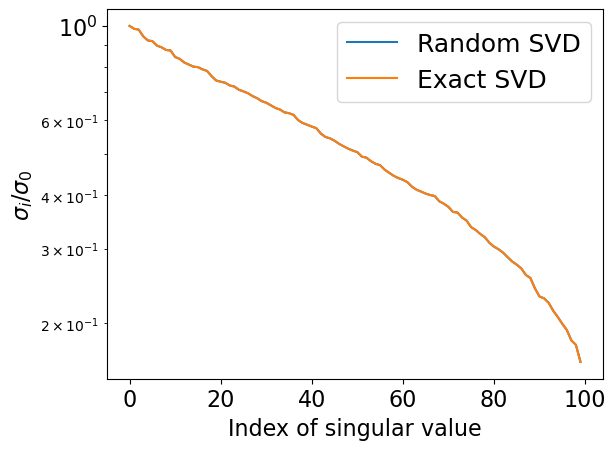

In [19]:
import matplotlib.pyplot as plt
import numpy as np

n = 1000
k = 100
m = 200
# Lowrank matrix
A = np.random.randn(n, k)
B = np.random.randn(k, m)
A = A @ B

# Random matrix
# A = np.random.randn(n, m)

def randomized_svd(A, rank, p):
    m, n = A.shape
    G = np.random.randn(n, rank + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B)
    U = Q @ u
    return U, S, V

rank = 100
p = 5
U, S, V = randomized_svd(A, rank, p)
print("Error from randomized SVD", np.linalg.norm(A - U[:, :rank] * S[None, :rank] @ V[:rank, :]))
plt.semilogy(S[:rank] / S[0], label="Random SVD")
u, s, v = np.linalg.svd(A)
print("Error from exact SVD", np.linalg.norm(A - u[:, :rank] * s[None, :rank] @ v[:rank, :]))
plt.semilogy(s[:rank] / s[0], label="Exact SVD")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

In [2]:
import scipy.sparse.linalg as spsplin
# More details about Facebook package for computing randomized SVD is here: https://research.fb.com/blog/2014/09/fast-randomized-svd/ 
import fbpca
n = 1000
m = 200
A = np.random.randn(n, m)
k = 10
p = 10
%timeit spsplin.svds(A, k=k)
%timeit randomized_svd(A, k, p)
%timeit fbpca.pca(A, k=k, raw=False) 

60.5 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.07 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.09 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Можно получить нетривиальные оценки сходимости

Усредненная ошибка представленного алгоритма, где $k$ - целевой ранг, а $p$ - параметр избыточной выборки, следующая
- в норме Фробениуса

$$ \mathbb{E}\|A - QQ^{\top}A \|_F \leq \left( 1 + \frac{k}{p-1} \right)^{1/2}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^2_j \right)^{1/2}  $$

- в спектральной норме

$$ \mathbb{E}\|A - QQ^{\top}A \|_2 \leq \left( 1 + \sqrt{\frac{k}{p-1}} \right)\sigma_{k+1} + \frac{e\sqrt{k+p}}{p}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^2_j \right)^{1/2} $$

Математическое ожидание берется относительно случайной матрицы $G$, сгенерированной в методе, описанном выше.

Сравните эти верхние границы с теоремой Экарта-Янга. Хороши ли эти границы?


## Умножив несколько раз, можно оценить больше сингулярных значений

- Основная идея: степенной метод
- Если $A = U \Sigma V^\top$, то $A^{(q)} = (AA^{\top})^qA = U \Sigma^{2q+1}V^\top $, где $q$ - некоторое небольшое натуральное число, например 1 или 2
- Затем мы делаем выборку из $A^{(q)}$, а не из $A$

$$ Y = (AA^{\top})^qAG \qquad Q, R = \mathtt{qr}(Y) $$

- Основная причина: если сингулярные значения $A$ убывают медленно, то сингулярные значения $A^{(q)}$ будут убывать быстрее

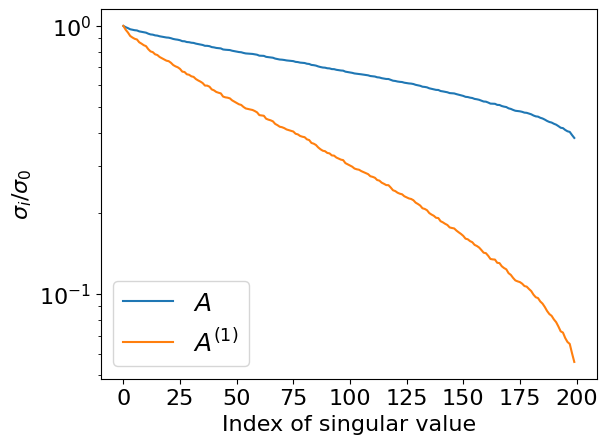

In [5]:
n = 1000
m = 200
A = np.random.randn(n, m)
s = np.linalg.svd(A, compute_uv=False)
Aq = A @ A.T @ A
sq = np.linalg.svd(Aq, compute_uv=False)
plt.semilogy(s / s[0], label="$A$")
plt.semilogy(sq / sq[0], label="$A^{(1)}$")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

## Потеря точности из-за ошибок округления, но мы сможем ее исправить
 
 Наивное составление $A^{(q)}$ приводит к росту числа обусловленности и потере точности
 
 **Q:** как мы можем бороться с этой проблемой?

**A:** sequential orthogonalization!

Error from randomized SVD 286.99760873015225
Error from more accurate randomized SVD 250.2388642432797
Error from exact SVD 249.3503301291079


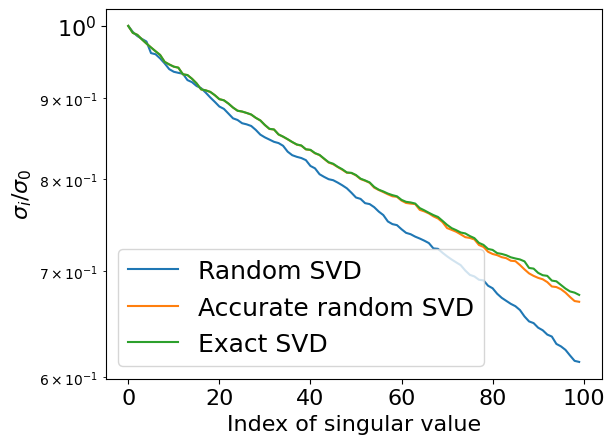

In [6]:
def more_accurate_randomized_svd(A, rank, p, q):
    m, n = A.shape
    G = np.random.randn(n, rank + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    for i in range(q):
        W = A.T @ Q
        W, _ = np.linalg.qr(W)
        Q = A @ W
        Q, _ = np.linalg.qr(Q)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B)
    U = Q @ u
    return U, S, V

n = 1000
m = 200
A = np.random.randn(n, m)

rank = 100
p = 20
U, S, V = randomized_svd(A, rank, p)
print("Error from randomized SVD", np.linalg.norm(A - U[:, :rank] * S[None, :rank] @ V[:rank, :]))
plt.semilogy(S[:rank] / S[0], label="Random SVD")

Uq, Sq, Vq = more_accurate_randomized_svd(A, rank, p, 5)
print("Error from more accurate randomized SVD", np.linalg.norm(A - Uq[:, :rank] * Sq[None, :rank] @ Vq[:rank, :]))
plt.semilogy(Sq[:rank] / Sq[0], label="Accurate random SVD")

u, s, v = np.linalg.svd(A)
print("Error from exact SVD", np.linalg.norm(A - u[:, :rank] * s[None, :rank] @ v[:rank, :]))
plt.semilogy(s[:rank] / s[0], label="Exact SVD")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

In [7]:
%timeit spsplin.svds(A, k=k)
%timeit fbpca.pca(A, k=k, raw=False)
%timeit randomized_svd(A, k, p) 
%timeit more_accurate_randomized_svd(A, k, p, 1)
%timeit more_accurate_randomized_svd(A, k, p, 2)
%timeit more_accurate_randomized_svd(A, k, p, 5)

347 ms ± 60.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
82.3 ms ± 6.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
68.7 ms ± 4.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
118 ms ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
176 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
352 ms ± 43.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Здесь тоже есть теорема сходимости

Представленный выше метод обеспечивает следующую верхнюю границу

$$ \mathbb{E}\|A - QQ^{\top}A \|_2 \leq \left[\left( 1 + \sqrt{\frac{k}{p-1}} \right)\sigma^{2q+1}_{k+1} + \frac{e\sqrt{k+p}}{p}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^{2(2q+1)}_j \right)^{1/2}\right]^{1/(2q+1)} $$

Рассмотрим наихудший случай, когда в данной матрице не существует структуры низкого ранга.

**Вопрос:** какова степень субоптимальности по отношению к теореме Экарта-Янга?

### Резюме по рандомизированному SVD

- Эффективный метод для получения приближенного SVD
- Прост в реализации
- Может быть расширен до однопроходного метода, где матрица $A$ нужна только для построения $Q$
- Требует только умножение матрицы на вектор с целевой матрицей

## Метод Качмажа (Kaczmarz method) для решения линейных систем позволяет приближенно решать, не считая даже все строки

- Мы уже обсудили, как решать переопределенные линейные системы $Ax = f$ в смысле наименьших квадратов
    - псевдообратная матрица
    - QR разложение
- Еще один подход основан на итеративных проекциях, известный как **метод Качмажа** или **алгебраический метод реконструкции** в области вычислительной томографии
- Вместо решения всех уравнений, выбираем одно случайно, которое имеет вид

$$a^{\top}_i x = f_i,$$

и имея приближение $x_k$, пытаемся найти $x_{k+1}$ как

$$x_{k+1} = \arg \min_x \frac12 \Vert x - x_k \Vert^2_2, \quad \mbox{s.t.} \quad  a^{\top}_i x = f_i.$$

- Простой анализ дает

$$x_{k+1} = x_k - \frac{(a_i, x_k) - f_i}{(a_i, a_i)} a_i. $$

- Это недорогое обновление, но анализ довольно сложный.
- В этом методе можно узнать стохастический градиентный спуск с определенным размером шага, равным $\frac{1}{\|a_i\|_2^2}$ для каждого образца

## Теорема сходимости была доказана очень недавно

- Предположим, что мы генерируем $i$ согласно распределению по всем доступным индексам пропорционально нормам строк, т.е. $\mathbb{P}[i = k] = \frac{\|a_k\|_2^2}{\| A \|^2_F}$. Этот метод называется рандомизированным методом Качмажа (RKM)
- Почему стратегия выборки здесь важна?
- Исследование наилучшей выборки представлено [здесь](https://scholar.harvard.edu/files/yuelu/files/randkac_globalsip14.pdf)
- Если переопределенная линейная система **совместна**, то

$$ \mathbb{E}[\|x_{k+1} - x^*\|^2_2] \leq \left(1 - \frac{1}{\kappa^2_F(A)}\right) \mathbb{E}[\|x_{k} - x^*\|^2_2], $$

где $\kappa_F(A) = \frac{\| A \|_F}{\sigma_{\min}(A)}$ и $\sigma_{\min}(A)$ - минимальное ненулевое сингулярное число матрицы $A$. Этот результат был представлен в работе ([Strohmer and Vershynin, 2009](http://people.eecs.berkeley.edu/~brecht/cs294docs/week1/09.Strohmer.pdf))

- Если переопределенная линейная система **несовместна**, то

$$ \mathbb{E}[\|x_{k+1} - x^*\|^2_2] \leq \left(1 - \frac{1}{\kappa^2_F(A)}\right) \mathbb{E}[\|x_{k} - x^*\|^2_2] + \frac{\|r^*\|_2^2}{\| A \|^2_F}, $$

где $r^* = Ax^* - f$

## Хотелось бы поговорить о скетчинге, но это уже другая история

- Выборка определенной строки может рассматриваться как частный случай более общего подхода, называемого **скетчингом**
- Идея: заменить матрицу $A$ другой матрицей $SA$, где матрица $SA$ имеет значительно меньшее количество строк, но сохраняет некоторые важные свойства матрицы $A$
- Возможные варианты:
    - случайная проекция
    - случайный выбор строк
- Пример: задача линейных наименьших квадратов $\|Ax - b\|_2^2 \to \min_x$ преобразуется в $\| (SA)y - Sb \|_2^2 \to \min_y$, и мы ожидаем, что $x \approx y$
- Решатель [Blendenpick](https://pdos.csail.mit.edu/~petar/papers/blendenpik-v1.pdf) основан на этой идее и превосходит по производительности процедуру LAPACK
- Более подробную информацию см. в работе [Sketching as a Tool for Numerical Linear Algebra](https://researcher.watson.ibm.com/researcher/files/us-dpwoodru/wNow3.pdf) автора D. Woodruff

### Резюме по рандомизированным методам решения линейных систем

- Семейство методов, простых в использовании
- Особенно полезны в задачах с потоковыми данными
- Существуют теоретические границы сходимости
- Множество интерпретаций в различных областях (SGD в глубоком обучении, ART в вычислительной томографии)

### Резюме по рандомизированному матричному умножению

- Простой метод для получения приближенного результата
- Может использоваться, если высокая точность не критична
- Особенно полезен для больших плотных матриц

## Следующая лекция
- Мы начинаем изучение **разреженной и/или структурированной** численной линейной алгебры.

Вопросы?